In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join

import pandas as pd
import re

In [2]:

files = [f for f in listdir("./") if isfile(join("./", f))]

r = re.compile(".*acc")
files = list(filter(r.match, files))

acc = []
for filename in files:
    acc. append(pd.read_csv(filename
        , header=None
        , index_col=False)[0])

acc = pd.DataFrame(acc)
acc.index = [file[:-13] for file in files]

acc.columns = ["Validation"]
acc

Validation
cover_crops          0.364086
water_type           0.742097
irrigation_type      0.841845
giregion             0.505824
irrigation_energy    0.746293
data_year_id         0.422003

In [3]:

files = [f for f in listdir("./") if isfile(join("./", f))]

r = re.compile(".*val")
files = list(filter(r.match, files))

all_acc = {}

for filename in files:
    filename = filename[:-8]
    
    conf_v = pd.read_csv(filename + "_val.csv", header=0, index_col=0)
    conf_a = pd.read_csv(filename + "_all.csv", header=0, index_col=0)

    conf_a.index = conf_a.index.astype(int)
    conf_a.columns = conf_a.columns.astype(int)
    conf_v.index = conf_v.index.astype(int)
    conf_v.columns = conf_v.columns.astype(int)

    conf_v = conf_v.fillna(0)
    conf_a = conf_a.fillna(0)

    conf_a = conf_a - conf_v

    conf_a = conf_a.fillna(0)

    total = conf_a.sum().sum()

    sums = 0
    for i in conf_a.index:
        try:
            sums += conf_a.loc[i, i]
        except:
            sums += 0
    all_acc[filename] = sums/total

acc["training"] = all_acc

In [4]:
acc

Validation  training
cover_crops          0.364086  0.396418
water_type           0.742097  0.928905
irrigation_type      0.841845  0.847554
giregion             0.505824  0.568242
irrigation_energy    0.746293  0.836405
data_year_id         0.422003  0.518059

In [5]:
cat_cols = [ # These are binary
    "water_type"
    , "cover_crops"
    , "irrigation_type"
    , "irrigation_energy"
    , "data_year_id" # These are one hot encoded
    , "giregion"
    , "nh_disease"
]

files = [f for f in listdir("./") if isfile(join("./", f))]

r = re.compile(".*imp")
files = list(filter(r.match, files))

df = pd.read_csv(files[0], index_col=0, names=[files[0][:-8]], header=0)

for filename in files:
    df[filename[:-8]] = pd.read_csv(filename, index_col=0, header=0).iloc[:,0]
    # pd.read_csv(filename, index_col=0, header=0)["values"]

# for col in list(set(cat_cols) - set(df.index)):
#     r = re.compile("{}.*".format(col))
#     rows = list(filter(r.match, list(df.index)))
#     df.loc[col] = df.loc[rows].mean()
#     df = df.drop(rows).copy()

df = df.stack().reset_index()
# df.columns = ["source", "linked", "value"]
df.columns = ["Predictor", "Response", "Value"]
df = df[["Response", "Predictor", "Value"]]

In [6]:
df = round(df)
df

Response                                          Predictor  \
0      total_grape_revenue                                    petrol_vineyard   
1        irrigation_energy                                    petrol_vineyard   
2          irrigation_type                                    petrol_vineyard   
3                 giregion                                    petrol_vineyard   
4               water_type                                    petrol_vineyard   
..                     ...                                                ...   
843    total_grape_revenue                      water_type_surface_water_dam    
844    total_grape_revenue          water_type_surface_water_dam mains_water    
845  total_operating_costs          water_type_surface_water_dam mains_water    
846    total_grape_revenue  water_type_surface_water_dam recycled_water_fr...   
847  total_operating_costs  water_type_surface_water_dam recycled_water_fr...   

      Value  
0     307.0  
1     963.0  
2      88.0  
3     384.0  
4    3475.0  
..      ...  
843     7.0  
844    13.0  
845     1.0  
846     4.0  
847     1.0  

[848 rows x 3 columns]

In [12]:
replacements = {
       'irrigation_energy': "Irrigation Energy Type"
       , 'irrigation_type': 'Irrigation System Type'
       , 'giregion': "Region"
       , 'water_type': 'Water Source'
       , 'profitable': 'Profitable'
       , 'profit': 'Profit'
       , 'electricity_vineyard': 'Electricity Used'
       , 'total_operating_costs': 'Operating Costs'
       , 'slashing_number_of_times_passes_per_year': 'Slashing Passes'
       , 'data_year_id': 'Year'
       , 'insecticide_spraying_number_of_times_passes_per_year': 'Insecticide Spraying'
       , 'diesel_vineyard': 'Diesel Used'
       , 'total_fertiliser': 'Fertiliser Applied'
       , 'herbicide_spraying_number_of_times_passes_per_year': 'Herbicide Spraying'
       , 'tonnes_grapes_harvested': 'Yield'
       , 'water_used': 'Water Used'
       , 'biodiesel_vineyard': 'Biodiesel Used'
       , 'vineyard_solar': 'Solar Energy'
       , 'petrol_vineyard': 'Petrol Used'
       , 'nh_disease': 'Disease Presence'
       , 'cover_crops': 'Cover Crop Type'
       , 'fungicide_spraying_number_of_times_passes_per_year': 'Fungicide Spraying'
       , 'lpg_vineyard': 'LPG Used'
       , 'area_harvested': 'Area Harvested'
       , "vineyard_wind": 'Wind Energy'
    , "cover_crops_ver_crop_non_native ": "Cover Crop: Non-native"
    , "cover_crops__crop ver_crop_non_native ": "Cover Crop: Non-native and Perennial"
    , "water_type_er_dam ": "Water Source: Dam"
    , "water_type_ ": "Water Source: River, Mains, Ground or Other"
    , "giregion_Hunter Valley": "Region: Hunter Valley"
    , "total_grape_revenue":  "Revenue"
    , "data_year_id_2021/2022": "Year (2021/2022)"
}
df["Predictor"] = df["Predictor"].replace(replacements)
df["Response"] = df["Response"].replace(replacements)

In [9]:
df = df.drop(df[df["Response"]==df["Predictor"]].index)
df["Value"] = round(df["Value"]).apply(int)
df

Response  \
0                   Revenue   
1    Irrigation Energy Type   
2    Irrigation System Type   
3                    Region   
4              Water Source   
..                      ...   
843                 Revenue   
844                 Revenue   
845         Operating Costs   
846                 Revenue   
847         Operating Costs   

                                             Predictor  Value  
0                                          Petrol Used    307  
1                                          Petrol Used    963  
2                                          Petrol Used     88  
3                                          Petrol Used    384  
4                                          Petrol Used   3475  
..                                                 ...    ...  
843                      water_type_surface_water_dam       7  
844          water_type_surface_water_dam mains_water      13  
845          water_type_surface_water_dam mains_water       1  
846  water_type_surface_water_dam recycled_water_fr...      4  
847  water_type_surface_water_dam recycled_water_fr...      1  

[848 rows x 3 columns]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
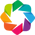

:Chord   [Response,Predictor]   (Value)

In [10]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)
chord = hv.Chord(df)
# edge_muted_line_width
# edge_line_width
# node_line_width
#  node_hover_line_width
# width
# min_width
# frame_width
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Response').str(), 
               labels='index', node_color=dim('index').str()))

# And we also do a Sankey Diagram!

## Profit

In [13]:
indices = df.loc[df["Response"]=="Revenue", "Value"].sort_values(ascending=False).head(10).index

sankey = hv.Sankey(df.loc[indices])
sankey.opts(width=600, height=400, labels="index", edge_color=dim('Predictor').str(), label_position="left", cmap="Category10")

:Sankey   [Response,Predictor]   (Value)

In [14]:
# indices = df[df["linked"].isin(df.loc[indices, "linked"].values)].index
chord = hv.Chord(df[
                 (df["Predictor"].isin(df.loc[indices, "Predictor"].values)) &
                 (df["Response"].isin(df.loc[indices, "Predictor"].values)) 
                     ])
chord.opts(
    opts.Chord(cmap='Category10', edge_cmap='Category10', edge_color=dim('Predictor').str(), 
               labels='index', node_color=dim('index').str()))

:Chord   [Response,Predictor]   (Value)

## Region

In [59]:
indices = df.loc[df["Response"]=="Region", "Value"].sort_values(ascending=False).head(10).index

sankey = hv.Sankey(df.loc[indices])
sankey.opts(width=600, height=400, labels="index", edge_color=dim('Predictor').str(), label_position="left")

:Sankey   [Response,Predictor]   (Value)

In [60]:
# indices = df[df["linked"].isin(df.loc[indices, "linked"].values)].index
chord = hv.Chord(df[
                 (df["Predictor"].isin(df.loc[indices, "Predictor"].values)) &
                 (df["Response"].isin(df.loc[indices, "Predictor"].values)) 
                     ])
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Response').str(), 
               labels='index', node_color=dim('index').str()))

:Chord   [Response,Predictor]   (Value)

## Year

In [61]:
indices = df.loc[df["Response"]=="Year", "Value"].sort_values(ascending=False).head(10).index

sankey = hv.Sankey(df.loc[indices])
sankey.opts(width=600, height=400, labels="index", edge_color=dim('Predictor').str(), label_position="left")

:Sankey   [Response,Predictor]   (Value)

In [62]:
# indices = df[df["linked"].isin(df.loc[indices, "linked"].values)].index
chord = hv.Chord(df[
                 (df["Predictor"].isin(df.loc[indices, "Predictor"].values)) &
                 (df["Response"].isin(df.loc[indices, "Predictor"].values)) 
                     ])
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Response').str(), 
               labels='index', node_color=dim('index').str()))

:Chord   [Response,Predictor]   (Value)

## Operating cost

In [63]:
indices = df.loc[df["Response"]=="Operating Costs", "Value"].sort_values(ascending=False).head(10).index

sankey = hv.Sankey(df.loc[indices])
sankey.opts(width=600, height=400, labels="index", edge_color=dim('Predictor').str(), label_position="left")

:Sankey   [Response,Predictor]   (Value)

In [64]:
# indices = df[df["linked"].isin(df.loc[indices, "linked"].values)].index
chord = hv.Chord(df[
                 (df["Predictor"].isin(df.loc[indices, "Predictor"].values)) &
                 (df["Response"].isin(df.loc[indices, "Predictor"].values)) 
                     ])
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Predictor').str(), 
               labels='index', node_color=dim('index').str()))

:Chord   [Response,Predictor]   (Value)

In [73]:
df.groupby("Response").sum().sort_values(by="Value", ascending=False).head(10)

Predictor  \
Response                                                                    
Water Source            Area HarvestedYieldElectricity UsedInsecticide...   
Disease Presence        Area HarvestedYieldElectricity UsedInsecticide...   
Irrigation Energy Type  Area HarvestedYieldElectricity UsedInsecticide...   
Slashing Passes         Area HarvestedYieldElectricity UsedInsecticide...   
Area Harvested          YieldElectricity UsedInsecticide SprayingFungi...   
Region                  Area HarvestedYieldElectricity UsedInsecticide...   
Petrol Used             Area HarvestedYieldElectricity UsedInsecticide...   
Fungicide Spraying      Area HarvestedYieldElectricity UsedInsecticide...   
Electricity Used        Area HarvestedYieldDiesel UsedLPG UsedPetrol U...   
Cover Crop Type         Area HarvestedYieldElectricity UsedInsecticide...   

                        Value  
Response                       
Water Source            34346  
Disease Presence        15958  
Irrigation Energy Type  14285  
Slashing Passes         14043  
Area Harvested           8971  
Region                   6677  
Petrol Used              6239  
Fungicide Spraying       5193  
Electricity Used         4418  
Cover Crop Type          4409

In [82]:
df.groupby("Response").max().sort_values(by="Value", ascending=False).head(10)

Predictor  Value
Response                                                          
Water Source                                   nh_disease_0   4455
Disease Presence        water_type_ter_from_other_source      3203
Slashing Passes          water_type_ter_from_other_source     3103
Area Harvested           water_type_ter_from_other_source     2167
Irrigation Energy Type  water_type_ter_from_other_source      1535
Petrol Used             water_type_ter_from_other_source      1489
Electricity Used                        water_type_ er_dam    1271
Fungicide Spraying       water_type_ter_from_other_source      993
Region                   water_type_ter_from_other_source      992
LPG Used                 water_type_ter_from_other_source      673